In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
df = pd.read_csv('C:/Users/Upmanyu/Documents/GWU/machine learning 1/forest-cover-type-prediction/train.csv')

In [3]:
df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [4]:
df.isnull().sum().sum() # sum of null values in the dataset

0

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Display dataset's summary statistics
print(df.describe())

                Id     Elevation        Aspect         Slope  \
count  15120.00000  15120.000000  15120.000000  15120.000000   
mean    7560.50000   2749.322553    156.676653     16.501587   
std     4364.91237    417.678187    110.085801      8.453927   
min        1.00000   1863.000000      0.000000      0.000000   
25%     3780.75000   2376.000000     65.000000     10.000000   
50%     7560.50000   2752.000000    126.000000     15.000000   
75%    11340.25000   3104.000000    261.000000     22.000000   
max    15120.00000   3849.000000    360.000000     52.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      15120.000000                    15120.000000   
mean                         227.195701                       51.076521   
std                          210.075296                       61.239406   
min                            0.000000                     -146.000000   
25%                           67.000000         

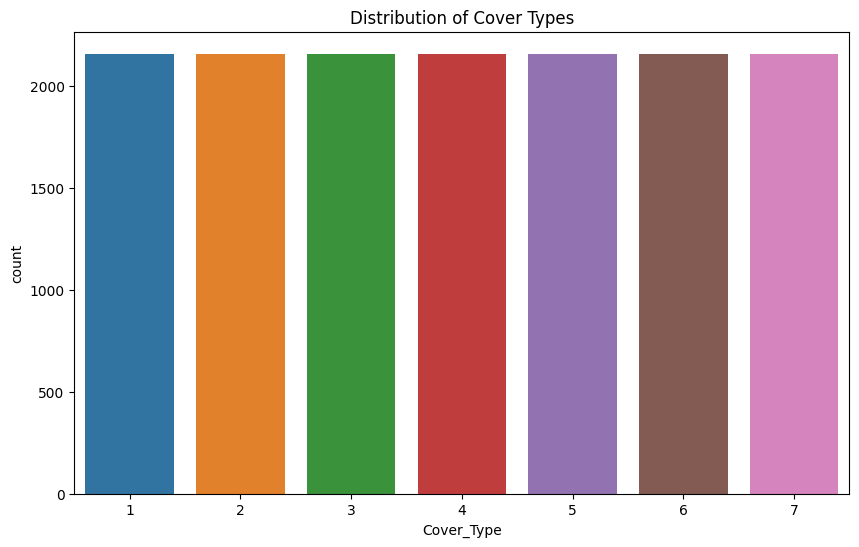

In [7]:
# Visualize the distribution of cover types
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Cover_Type')
plt.title('Distribution of Cover Types')
plt.show()


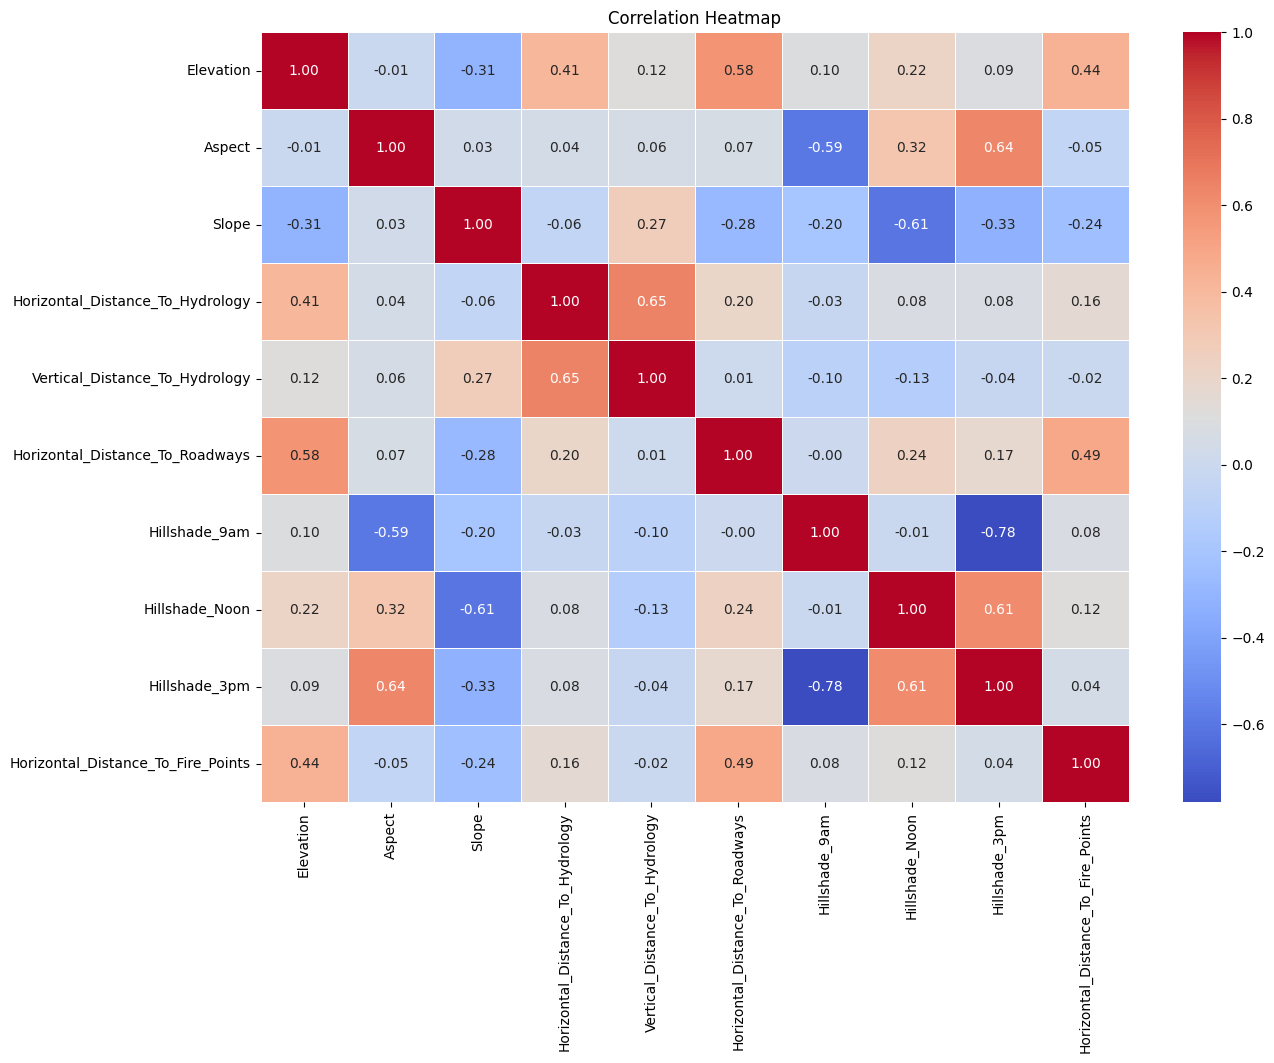

In [8]:
cols = []
for i in df.columns:
    if ('soil' in i.lower()) or ('wilderness' in i.lower()) or ('type' in i.lower()) or ('id' in i.lower()):
        continue
    else:
        cols.append(i)
# Compute the correlation matrix
corr_matrix = df[cols].corr()
    
# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


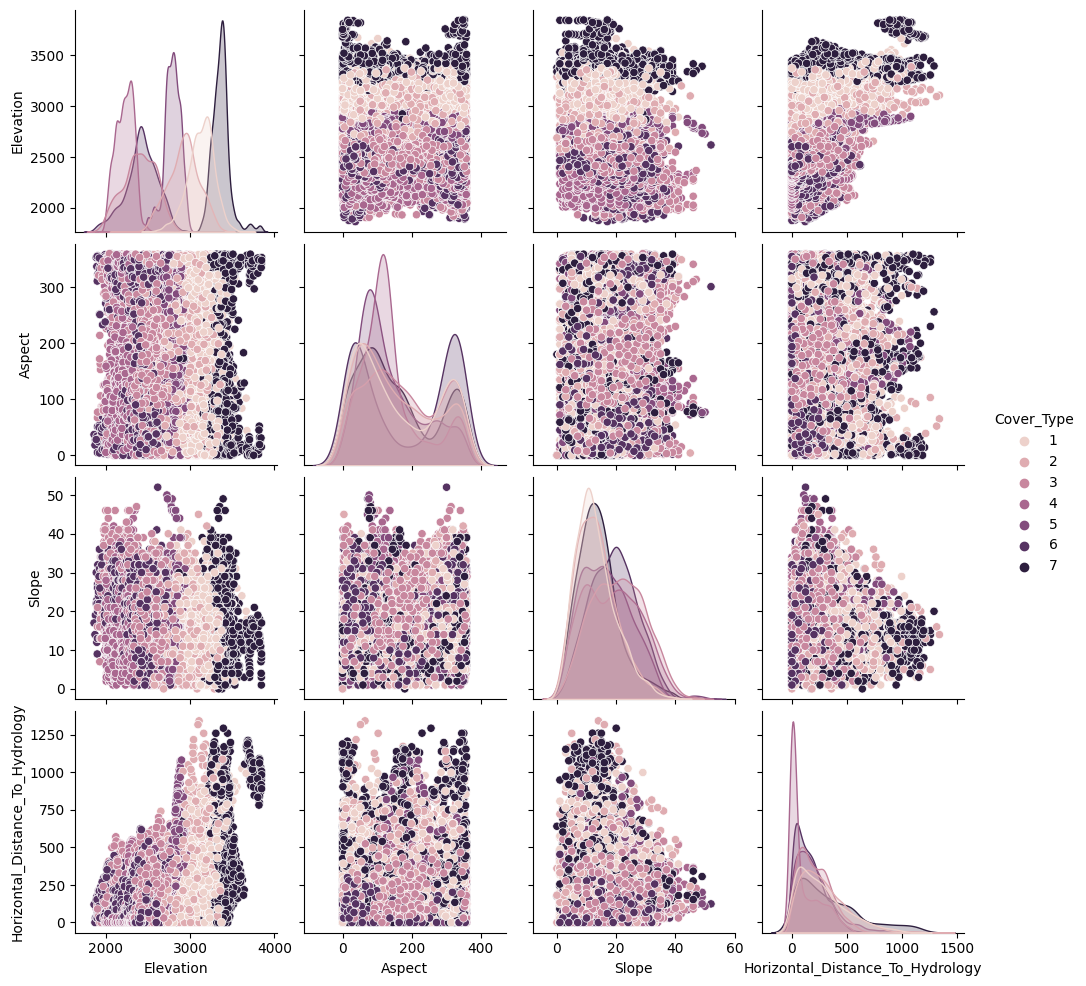

In [9]:
# Visualize relationships between selected features using a pairplot
subset_features = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Cover_Type']
sns.pairplot(df[subset_features], hue='Cover_Type')
plt.show()

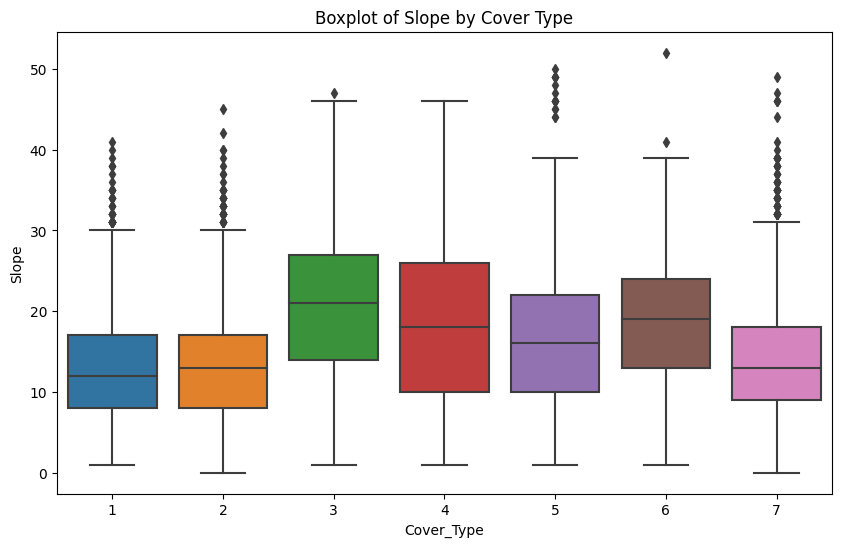

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Cover_Type', y='Slope')
plt.title('Boxplot of Slope by Cover Type')
plt.show()

def remove_outliers(data, column, multiplier=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Remove outliers for the 'Slope' feature
cleaned_data = remove_outliers(df, 'Slope')

In [11]:
df.shape, cleaned_data.shape

((15120, 56), (15063, 56))

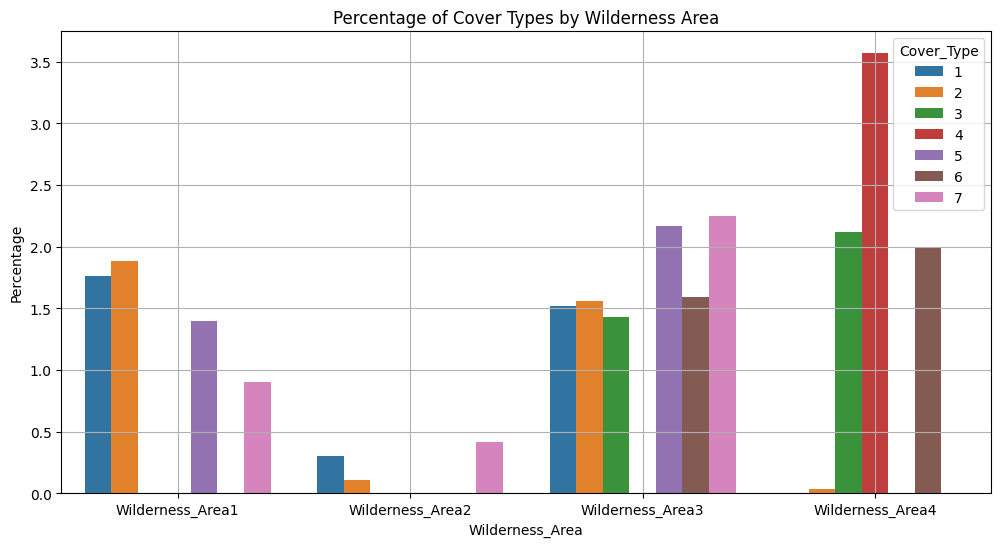

In [12]:
wilderness_cols = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']
wilderness_data = cleaned_data.melt(id_vars='Cover_Type', value_vars=wilderness_cols, var_name='Wilderness_Area', value_name='Present')

wilderness_data.head()
plt.figure(figsize=(12, 6))
sns.barplot(data=wilderness_data[wilderness_data['Present'] == 1], x='Wilderness_Area', y='Present', hue='Cover_Type', estimator=lambda x: len(x) / len(wilderness_data) * 100)
plt.ylabel('Percentage')
plt.grid()
plt.title('Percentage of Cover Types by Wilderness Area')
plt.show()


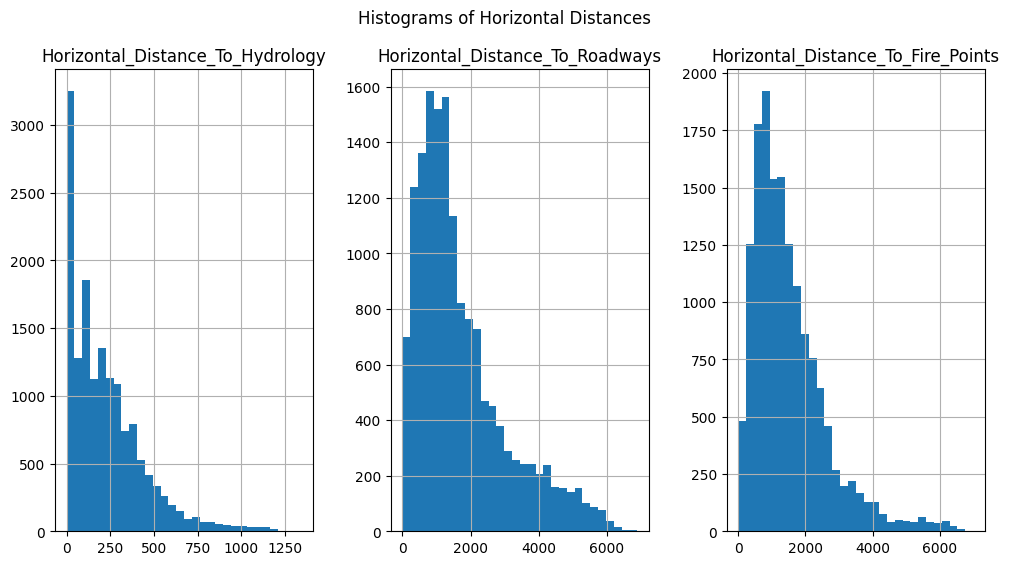

In [13]:
distance_cols = ['Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']
df[distance_cols].hist(bins=30, figsize=(12, 6), layout=(1, 3))
plt.suptitle('Histograms of Horizontal Distances')
plt.show()


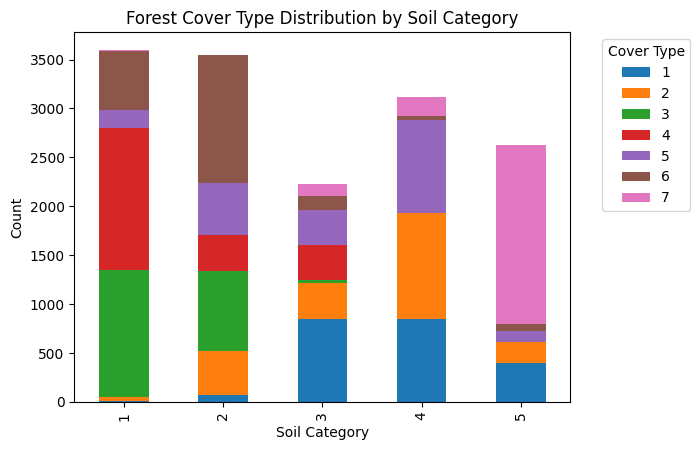

In [14]:


# Assuming the new soil categories are defined as follows:
# Category 1: Soil_Type1 - Soil_Type8
# Category 2: Soil_Type9 - Soil_Type16
# Category 3: Soil_Type17 - Soil_Type24
# Category 4: Soil_Type25 - Soil_Type32
# Category 5: Soil_Type33 - Soil_Type40

def get_soil_category(row):
    for i in range(1, 6):
        if row[f'Soil_Type{(i-1)*8+1}'] == 1:
            return i
        if row[f'Soil_Type{(i-1)*8+2}'] == 1:
            return i
        if row[f'Soil_Type{(i-1)*8+3}'] == 1:
            return i
        if row[f'Soil_Type{(i-1)*8+4}'] == 1:
            return i
        if row[f'Soil_Type{(i-1)*8+5}'] == 1:
            return i
        if row[f'Soil_Type{(i-1)*8+6}'] == 1:
            return i
        if row[f'Soil_Type{(i-1)*8+7}'] == 1:
            return i
        if row[f'Soil_Type{(i-1)*8+8}'] == 1:
            return i
    return np.nan

# Create a new column for the aggregated soil categories
df['Soil_Category'] = df.apply(get_soil_category, axis=1)

# Create a bar plot of the aggregated soil categories and forest cover types
soil_category_cover_type = df.groupby(['Soil_Category', 'Cover_Type']).size().unstack()
soil_category_cover_type.plot(kind='bar', stacked=True)
plt.xlabel('Soil Category')
plt.ylabel('Count')
plt.title('Forest Cover Type Distribution by Soil Category')
plt.legend(title='Cover Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [15]:
##Training data

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score

In [16]:
# Split the data into features (X) and target (y)
X = cleaned_data.drop(columns=["Id", "Cover_Type"])
y = cleaned_data["Cover_Type"]

# Split the dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the pipeline steps
pipeline_steps = [
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier())
]

# Create the pipeline
pipeline = Pipeline(pipeline_steps)

# Define the model and hyperparameter options for GridSearchCV
models = [
    {
        'model': [RandomForestClassifier()],
        'model__n_estimators': [10, 50, 100],
        'model__max_depth': [None, 10, 20]
    },
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': [3, 5, 7]
    },
    {
        'model': [MLPClassifier()],
        'model__hidden_layer_sizes': [(50,), (100,)],
        'model__activation': ['relu', 'tanh'],
        'model__solver': ['adam'],
        'model__max_iter': [200]
    },
    {
        'model': [DecisionTreeClassifier()],
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10]
    }
]

# Create GridSearchCV with the pipeline and model options
grid_search = GridSearchCV(pipeline, models, cv=5, scoring='f1_macro', verbose=2, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best model and its score
print(f"Best model: {grid_search.best_estimator_}")
print(f"Best F1 macro score: {grid_search.best_score_}")

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Test F1 macro score: {test_f1_macro}")

Fitting 5 folds for each of 37 candidates, totalling 185 fits
Best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier())])
Best F1 macro score: 0.8508486851259134
Test F1 macro score: 0.8537168377584049


array([[-0.47784641, -1.0920457 ,  0.18589037, ..., -0.22466667,
        -0.21385654, -0.17523522],
       [ 1.57810909, -0.29213656,  0.06568758, ...,  4.45103857,
        -0.21385654, -0.17523522],
       [-1.7075768 , -0.45575434,  1.38791825, ..., -0.22466667,
        -0.21385654, -0.17523522],
       ...,
       [-1.17917702,  1.7803553 ,  1.26771546, ..., -0.22466667,
        -0.21385654, -0.17523522],
       [ 0.35318233,  0.88954739, -1.1363403 , ..., -0.22466667,
        -0.21385654, -0.17523522],
       [ 1.26347104, -0.85570891, -0.89593472, ...,  4.45103857,
        -0.21385654, -0.17523522]])

In [27]:
df_val = pd.read_csv('C:/Users/Upmanyu/Documents/GWU/machine learning 1/forest-cover-type-prediction/test.csv')
df_val_1 = df_val.drop(['Id'],axis=1)

In [28]:
df_val.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

In [29]:
X_val = scaler.transform(df_val_1)

In [31]:
df_val['Cover_Type'] = best_model.predict(X_val)

In [34]:
df_val[['Id','Cover_Type']].to_csv('submission.csv',index=False)